# __mfusg_freyberg__

In [ ]:
# pip install pooch

In [12]:
from pathlib import Path
from pprint import pformat
# import git
import pooch
import flopy
import matplotlib.pyplot as plt
from flopy.discretization import UnstructuredGrid                               # ____ Dependency
from flopy.utils.geometry import LineString                                     # ____ Dependency 
import os
import numpy as np
from pathlib import Path
from tempfile import TemporaryDirectory

In [2]:
try:                                                                            # ___ Download 
    root = Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None

#### __To_new_folder__ `freyberg.usg`

In [3]:
root_name = "freyberg.usg"      
data_path = root / "examples" / "data" if root else Path.cwd()
file_names = {"freyberg.usg.bas": None, "freyberg.usg.disu": None, "freyberg.usg.ghb": None, "freyberg.usg.gnc": None,    
              "freyberg.usg.gsf": None, "freyberg.usg.gsf.with_comment": None, "freyberg.usg.lpf": None, "freyberg.usg.nam": None,    
              "freyberg.usg.oc": None, "freyberg.usg.rch": None, "freyberg.usg.sfr": None,    "freyberg.usg.sms": None, "freyberg.usg.wel": None,}
for fname, fhash in file_names.items():
    pooch.retrieve(url=f"https://github.com/modflowpy/flopy/raw/develop/examples/data/{root_name.replace('.', '_')}/{fname}",    
        fname=fname, path=data_path / root_name.replace(".", "_"), known_hash=None,)

In [4]:
A_ws = data_path / root_name.replace(".", "_")                                  # root to A_ws ___but not folder (freyberg.usg)
mfgrid = UnstructuredGrid.from_gridspec(str(A_ws / f"{root_name}.gsf"))

In [5]:
B_gwf = flopy.mfusg.MfUsg.load(f"{root_name}.nam", model_ws=str(A_ws), verbose=False, check=False, exe_name="mfusg",)                         

In [6]:
B_gwf.write_input()          # _____ to the new dir

### __write_01__

In [7]:
bas6 = B_gwf.get_package("bas6")
ibound = bas6.ibound.array

### __write_02__

In [8]:
B_gwf.write_input()          # _____ to the new dir

In [9]:
lines = [LineString(ls)
    for ls in [ [(623000, 3364000), (623000, 3372000)], [(623650, 3364000), (623650, 3372000)],]]            # lines

#### __New__Dir_Temp__

In [22]:
from tempfile import TemporaryDirectory
temp_dir = TemporaryDirectory()
work_dir = Path(temp_dir.name) / "freyberg_usg"
B_gwf.change_model_ws(str(work_dir))
B_gwf.write_name_file()
B_gwf.write_input()
success, buff = B_gwf.run_model(silent=True, report=True)
assert success, pformat(buff)


creating model workspace...
   C:\Users\GROSS~1.DES\AppData\Local\Temp\tmp1euupo10\freyberg_usg


#### __New__Dir__Zable__

In [10]:
temp_dir = os.path.join('Zable')
B_gwf.change_model_ws(str(temp_dir))
B_gwf.write_name_file()
B_gwf.write_input()
success, buff = B_gwf.run_model(silent=True, report=True)
assert success, pformat(buff)


creating model workspace...
   Zable


# __Plot__from_temp__ "     " __not_from_Zable__

In [23]:
hds = flopy.utils.HeadUFile(str(work_dir / f"{root_name}.hds"), model= B_gwf)
times = hds.get_times()
head = np.array(hds.get_data())
print(head.shape)

(3, 1499)


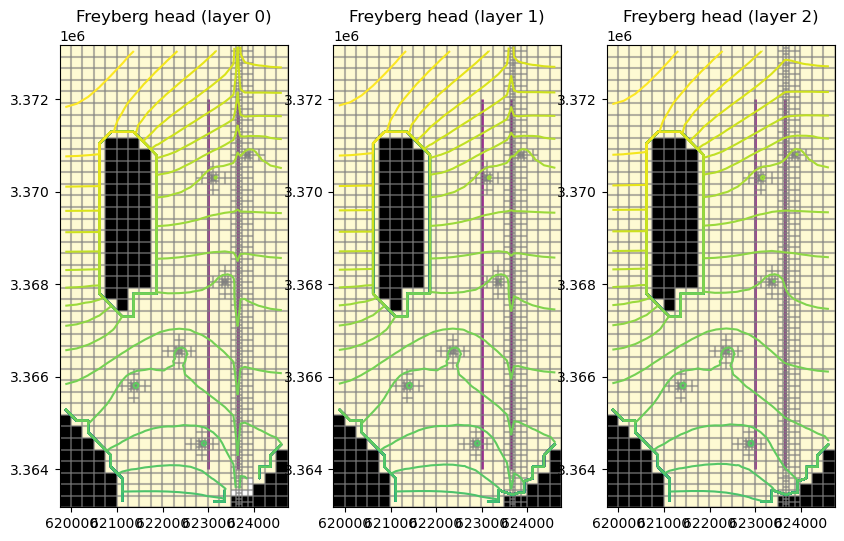

In [24]:
levels = np.arange(30, 35.4, 0.1)
fig = plt.figure(figsize=(10, 6))

for layer, h in enumerate(head):
    ax = fig.add_subplot(1, len(head), layer + 1)
    
    ax.set_title(f"Freyberg head (layer {layer})")
    
    pmv = flopy.plot.PlotMapView(modelgrid=mfgrid, ax=ax)
    mesh = pmv.plot_array(h, alpha=0.2)
    grid = pmv.plot_grid(alpha=0.2)
    shps = pmv.plot_shapes(lines, edgecolor="purple", lw=2, alpha=0.8)        # lines
    inac = pmv.plot_inactive(ibound=ibound)
    ctrs = pmv.contour_array(h, levels=levels)